In [1]:
import gym
import gym_point
import numpy as np
import torch
from util import PGN, RewardNet, GRL, float32_preprocessor
from matplotlib import pyplot as plt
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
## Intention Estimation 
env = gym.make('PointContinuousEnv-v0')
env.set_curve('S') # Curve: 'S', 'C'
env.set_reset_condition('origin') # reset state: 'origin', 'random'

agent_net_C = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net_C = RewardNet(env.observation_space.shape[0] + 1)
agent_net_S = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net_S = RewardNet(env.observation_space.shape[0] + 1)
agent_net_CRev = PGN(env.observation_space.shape[0], env.action_space.n)
reward_net_CRev = RewardNet(env.observation_space.shape[0] + 1)

/home/sagrawal/src/gym/gym/logger.py:30: UserWarning: WARN: The dimensions are bigger than 2, only the first 2 dimensions are visualized
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [14]:
checkpoint = torch.load('Results/S_origin/S_pointspace_policy_net_origin.mod')
agent_net_S.load_state_dict(checkpoint)
agent_net_S.to(device)

checkpoint = torch.load('Results/S_origin/S_pointspace_reward_net_origin.mod')
reward_net_S.load_state_dict(checkpoint)
reward_net_S.to(device)

checkpoint = torch.load('Results/C_origin/C_pointspace_policy_net_origin.mod')
agent_net_C.load_state_dict(checkpoint)
agent_net_C.to(device)

checkpoint = torch.load('Results/C_origin/C_pointspace_reward_net_origin.mod')
reward_net_C.load_state_dict(checkpoint)
reward_net_C.to(device)

checkpoint = torch.load('pointspace_policy_net_origin.mod')
agent_net_CRev.load_state_dict(checkpoint)
agent_net_CRev.to(device)

checkpoint = torch.load('pointspace_reward_net_origin.mod')
reward_net_CRev.load_state_dict(checkpoint)
reward_net_CRev.to(device)

RewardNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Total number of demonstrations:  1
Total number of step demonstrations:  100


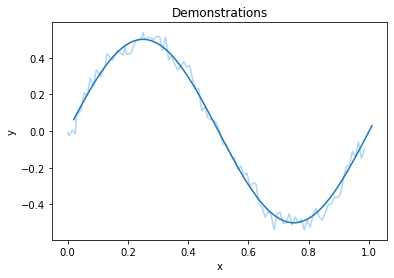

In [15]:
grl = GRL(env, noise=0.03)
demonstrations, XStore_steps, AStore_steps = grl.get_demonstrations(Ndemo=1, Kp=-100, Kd=-3)

In [38]:
## Testing 
agent_net_S.eval()
reward_net_S.eval()
agent_net_C.eval()
reward_net_C.eval()
agent_net_CRev.eval()
reward_net_CRev.eval()

for i in range(10):
    state = env.reset()
    Reward = 0
    Prob_C = 1
    Prob_S = 1
    done = False
    Ra = []
    while not done:
        env.render()
        
        _, prob_crev = agent_net_CRev.get_action(state) #
        action, prob_s = agent_net_S.get_action(state)
        _, prob_c = agent_net_C.get_action(state)
        
#         for action in range(9):
#             x = torch.cat((float32_preprocessor([state]), float32_preprocessor([action]).view(-1,1)), dim=1).to(device)
#             reward = reward_net_S(x)
#             Ra.append(reward)
            
#         action = np.argmax(Ra)
        next_state, reward, done, _ = env.step(int(action))
#         x = torch.cat((float32_preprocessor([state]), float32_preprocessor([action]).view(-1,1)), dim=1).to(device)
#         reward = reward_net_CRev(x).cpu()
        Reward += reward
#         Prob_C *= prob_c[action] # 9 actions
#         Prob_S *= prob_s[action]
#         estimate_c = 100*Prob_C/(Prob_C+Prob_S)
#         estimate_s = 100*Prob_S/(Prob_C+Prob_S)
#         print("S: ", estimate_s, "C: ", estimate_c)
        state = deepcopy(next_state)
    print("Trial :", i, " Reward: ", Reward)
env.close()

Trial : 0  Reward:  100
Trial : 1  Reward:  94
Trial : 2  Reward:  100
Trial : 3  Reward:  78
Trial : 4  Reward:  90
Trial : 5  Reward:  96
Trial : 6  Reward:  97
Trial : 7  Reward:  83
Trial : 8  Reward:  96
Trial : 9  Reward:  92


In [39]:
## Testing 
agent_net_S.eval()
reward_net_S.eval()
agent_net_C.eval()
reward_net_C.eval()

for i in range(1):
    state = env.reset()
    Reward = 0
    done = False
    Ra = []
    while not done:
        env.render()
#         for action in range(9):
#             x = torch.cat((float32_preprocessor([state]), float32_preprocessor([action]).view(-1,1)), dim=1).to(device)
#             reward = reward_net_S(x)
#             Ra.append(reward)
#         action = np.argmax(Ra)
        action = agent_net_S.get_action(state)
        next_state, reward, done, _ = env.step(action)    
        state = deepcopy(next_state)
        Reward += reward
    print("Trial :", i, " Reward: ", Reward)
env.close()

Trial : 0  Reward:  3


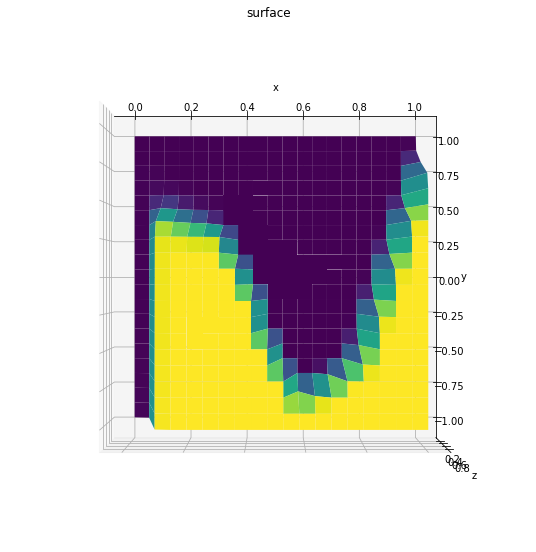

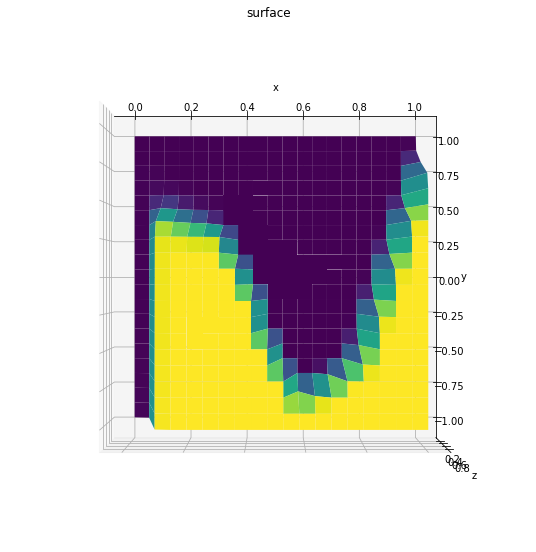

In [22]:
reward_net_S.visualize_net(agent_net_C, Npoints=20)